In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import findspark
findspark.init()
import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.ml.feature import VectorAssembler,MinMaxScaler,StandardScaler
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
conf = SparkConf().setMaster("local[*]")
sc = SparkContext(conf=conf)

In [4]:
spark = SparkSession\
    .builder\
    .appName("MyApp")\
    .getOrCreate()

## Load the dataset

In [5]:
df = spark.read\
    .format("csv")\
    .option("header", "true")\
    .option("inferschema", "true")\
    .option("delimiter",",")\
    .load("Datasets/Data-Energy.dat")#.repartition(3)

## Explore the dataset

In [6]:
df.show(5)

+------+-----+---+---+---+---+-------------+
|    B2|    G| DO| Dz| P1| P2|            E|
+------+-----+---+---+---+---+-------------+
| 0.005|0.002|  5|0.5|100| 10|0.79466009896|
|0.0075|0.002|  5|0.5|100| 10|1.30668533519|
|  0.01|0.002|  5|0.5|100| 10|1.56549009743|
| 0.015|0.002|  5|0.5|100| 10|1.74337854203|
|  0.02|0.002|  5|0.5|100| 10|1.78947156288|
+------+-----+---+---+---+---+-------------+
only showing top 5 rows



In [7]:
df.printSchema()

root
 |-- B2: double (nullable = true)
 |-- G: double (nullable = true)
 |-- DO: integer (nullable = true)
 |-- Dz: double (nullable = true)
 |-- P1: integer (nullable = true)
 |-- P2: integer (nullable = true)
 |-- E: double (nullable = true)



In [8]:
df.columns

['B2', 'G', 'DO', 'Dz', 'P1', 'P2', 'E']

In [9]:
len(df.columns)

7

In [10]:
df.count()

43

In [11]:
#df.describe().show()
df.describe().toPandas()

,summary,B2,G,DO,Dz,P1,P2,E
0,count,43,43,43,43,43,43,43
1,mean,0.01936046511627908,0.001965116279069769,5.209302325581396,0.4674418604651163,91.62790697674419,15.232558139534884,1.5575562065350228
2,stddev,0.003822436242259001,3.344389195640339E-4,0.8326131993647276,0.11067096283806276,20.345846956371542,13.97078108956302,1.0178889660513077
3,min,0.005,5.0E-4,4,0.0,20,5,0.0
4,max,0.03,0.003,9,0.6,100,70,4.32370124599


In [12]:
L = [[cn,df.stat.corr("E",cn)] for cn in df.columns]

In [13]:
df_corr = spark.createDataFrame(L).toDF("colname","correlation")

In [14]:
df_corr.select(col("colname"),abs(col("correlation")))\
    .sort(col("abs(correlation)").desc()).show()

+-------+-------------------+
|colname|   abs(correlation)|
+-------+-------------------+
|      E|                1.0|
|     P2| 0.7872785515582431|
|     P1| 0.4624966717181379|
|     Dz|0.35892186537488774|
|      G| 0.2895968016425225|
|     DO| 0.1852595379889137|
|     B2|0.10149763084928337|
+-------+-------------------+



## Apply Vector Assembler

In [15]:
features = df.columns[0:len(df.columns)-1]
features

['B2', 'G', 'DO', 'Dz', 'P1', 'P2']

In [16]:
assembler = VectorAssembler()\
    .setInputCols(features)\
    .setOutputCol("features")

In [17]:
df_v = assembler.transform(df)\
    .select(col("features"), col("E").alias("label"))

df_v.show(10)

+--------------------+--------------+
|            features|         label|
+--------------------+--------------+
|[0.005,0.002,5.0,...| 0.79466009896|
|[0.0075,0.002,5.0...| 1.30668533519|
|[0.01,0.002,5.0,0...| 1.56549009743|
|[0.015,0.002,5.0,...| 1.74337854203|
|[0.02,0.002,5.0,0...| 1.78947156288|
|[0.025,0.002,5.0,...|  1.7823812601|
|[0.03,0.002,5.0,0...| 1.74667199456|
|[0.02,0.002,5.0,0...|           0.0|
|[0.02,0.002,5.0,0...|0.346016525868|
|[0.02,0.002,5.0,0...|0.696187793454|
+--------------------+--------------+
only showing top 10 rows



## Split into train and test sets

In [18]:
trainingData, testData = df_v.randomSplit([0.7, 0.3])

## Scale the features

In [19]:
scaler = MinMaxScaler()\
    .setInputCol("features")\
    .setOutputCol("scaledFeatures") #StandardScaler

In [20]:
s = scaler.fit(trainingData)

In [21]:
trainingData_s = s.transform(trainingData)
testData_s = s.transform(testData)

## Train the model

In [22]:
lr = LinearRegression()\
    .setMaxIter(100)\
    .setElasticNetParam(1.0)\
    .setFeaturesCol("scaledFeatures")
    #.setLabelCol("y") #by default input columns: label and features

In [23]:
model = lr.fit(trainingData_s)

In [24]:
model.summary.r2

0.9913010033397337

In [25]:
model.summary.totalIterations

1

In [26]:
model.coefficients

DenseVector([0.1605, 1.7233, -1.1164, 1.3816, 1.7622, 2.6071])

In [27]:
model.intercept

-2.310963395156646

## Make predictions

In [28]:
predictions = model.transform(testData_s)
#predictions.show(5)
predictions.toPandas()

,features,label,scaledFeatures,prediction
0,"[0.005, 0.002, 5.0, 0.5, 100.0, 10.0]",0.794660,"[-0.25000000000000006, 0.5, 0.25, 1.0, 1.0, 0....",1.612314
1,"[0.0075, 0.002, 5.0, 0.5, 100.0, 10.0]",1.306685,"[-0.12500000000000006, 0.5, 0.25, 1.0, 1.0, 0....",1.632383
2,"[0.02, 0.0005, 5.0, 0.5, 100.0, 10.0]",0.233254,"[0.5000000000000001, -0.25, 0.25, 1.0, 1.0, 0....",0.440254
3,"[0.02, 0.002, 5.0, 0.0, 100.0, 10.0]",0.000000,"[0.5000000000000001, 0.5, 0.25, -0.25, 1.0, 0....",0.005708
4,"[0.02, 0.002, 5.0, 0.4, 100.0, 10.0]",1.416784,"[0.5000000000000001, 0.5, 0.25, 0.750000000000...",1.387321
5,"[0.02, 0.002, 5.0, 0.5, 40.0, 10.0]",0.317412,"[0.5000000000000001, 0.5, 0.25, 1.0, 0.25, 0.0...",0.411042
6,"[0.02, 0.002, 5.0, 0.5, 50.0, 10.0]",0.507779,"[0.5000000000000001, 0.5, 0.25, 1.0, 0.375, 0....",0.631323
7,"[0.02, 0.002, 5.0, 0.5, 70.0, 10.0]",0.971387,"[0.5000000000000001, 0.5, 0.25, 1.0, 0.625, 0....",1.071883
8,"[0.02, 0.002, 5.0, 0.5, 80.0, 10.0]",1.233964,"[0.5000000000000001, 0.5, 0.25, 1.0, 0.75, 0.0...",1.292164
9,"[0.02, 0.002, 5.0, 0.5, 100.0, 10.0]",1.789472,"[0.5000000000000001, 0.5, 0.25, 1.0, 1.0, 0.09...",1.732724


## Evaluate the model

In [29]:
evaluator = RegressionEvaluator().setMetricName("r2")
    #.setLabelCol("label")\
    #.setPredictionCol("prediction")

In [30]:
r2 = evaluator.evaluate(predictions)
r2

0.9419021087204178

## Compare data with predictions

In [31]:
y = predictions.select("label").collect()
y = [y[row][0] for row in range(0,len(y))]

In [32]:
y_p = predictions.select("prediction").collect()
y_p = [y_p[row][0] for row in range(0,len(y_p))]

In [33]:
d = predictions.select(predictions.prediction-predictions.label).collect()
d = [d[row][0] for row in range(0,len(d))]

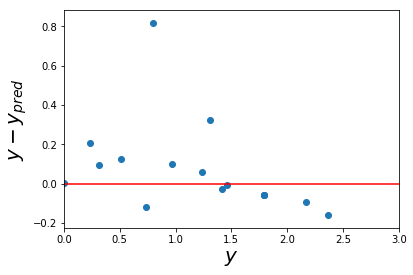

In [34]:
plt.scatter(y, d)
plt.plot([0,3],[0,0],c='r')
plt.xlim([0,3])
plt.xlabel('$y$',fontsize=20)
plt.ylabel('$y-y_{pred}$',fontsize=20)
plt.show()

## Save and load the model

In [35]:
model.save("LR-Model")

In [36]:
model_2 = LinearRegressionModel.load("LR-Model")

In [37]:
predictions_2 = model_2.transform(testData_s)
#predictions_2.show(5)
predictions_2.toPandas()

,features,label,scaledFeatures,prediction
0,"[0.005, 0.002, 5.0, 0.5, 100.0, 10.0]",0.794660,"[-0.25000000000000006, 0.5, 0.25, 1.0, 1.0, 0....",1.612314
1,"[0.0075, 0.002, 5.0, 0.5, 100.0, 10.0]",1.306685,"[-0.12500000000000006, 0.5, 0.25, 1.0, 1.0, 0....",1.632383
2,"[0.02, 0.0005, 5.0, 0.5, 100.0, 10.0]",0.233254,"[0.5000000000000001, -0.25, 0.25, 1.0, 1.0, 0....",0.440254
3,"[0.02, 0.002, 5.0, 0.0, 100.0, 10.0]",0.000000,"[0.5000000000000001, 0.5, 0.25, -0.25, 1.0, 0....",0.005708
4,"[0.02, 0.002, 5.0, 0.4, 100.0, 10.0]",1.416784,"[0.5000000000000001, 0.5, 0.25, 0.750000000000...",1.387321
5,"[0.02, 0.002, 5.0, 0.5, 40.0, 10.0]",0.317412,"[0.5000000000000001, 0.5, 0.25, 1.0, 0.25, 0.0...",0.411042
6,"[0.02, 0.002, 5.0, 0.5, 50.0, 10.0]",0.507779,"[0.5000000000000001, 0.5, 0.25, 1.0, 0.375, 0....",0.631323
7,"[0.02, 0.002, 5.0, 0.5, 70.0, 10.0]",0.971387,"[0.5000000000000001, 0.5, 0.25, 1.0, 0.625, 0....",1.071883
8,"[0.02, 0.002, 5.0, 0.5, 80.0, 10.0]",1.233964,"[0.5000000000000001, 0.5, 0.25, 1.0, 0.75, 0.0...",1.292164
9,"[0.02, 0.002, 5.0, 0.5, 100.0, 10.0]",1.789472,"[0.5000000000000001, 0.5, 0.25, 1.0, 1.0, 0.09...",1.732724
